# L2 $\lambda$ Cross Validation Analysis

### Abstract
_(10/08/20):_ This notebook plots the results of an experiment to find an optimal L2 $\lambda$ value for linear decoding models. The models in question use neural activity to decode latent behavioral features discovered by a (behavenet) auto-encoder. 

### Method
Here we compare cross validation over 8 different $\lambda$ values, when using either 400 or 1300 neurons in decoding. For each sample size of neurons, and each $\lambda$ value, we've trained 50 models using random samples of N neurons. We then average the error across all 50 trials for each cross validated value, and plot the mean squared test error.


In [ ]:
import os
import pickle
import scipy
import scipy.io as sio
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm

plt.style.use('fast')

matplotlib.rcParams.update({'font.size': 18, 'figure.figsize': (16, 8)})
from behavenet import get_user_dir, make_dir_if_not_exists
from behavenet.data.utils import get_transforms_paths
from behavenet.data.utils import load_labels_like_latents
from behavenet.fitting.utils import get_expt_dir
from behavenet.fitting.utils import get_session_dir
from behavenet.fitting.utils import get_best_model_version
from behavenet.fitting.utils import get_lab_example

from behavenet.fitting.utils import get_best_model_and_data
from behavenet.fitting.eval import export_predictions
from behavenet.models import Decoder

save_outputs = True  # true to save figures/movies to user's figure directory
format = 'png'  # figure format ('png' | 'jpeg' | 'pdf'); movies saved as mp4

from sklearn.metrics import r2_score

The following function defines the hyperparameters of a specific model (specifying different versions will let us select models with different $\lambda$ values). We first compute a random chance error as the mean squared error between the mean values for latents seen in training vs. test latents. Then we can load the actual predictons of our model to get the true MSE for a given trial.  

In [30]:
def latent_results(expt_name=None, sess_id='', version='best'):
    # set model info
    sess_idx = 0
    hparams = {
        'data_dir': get_user_dir('data'),
        'save_dir': get_user_dir('save'),
        'model_class': 'neural-ae',
        'ae_model_type': 'conv',
        'ae_model_class': 'ae',
        'ae_experiment_name': 'latent_search',
        'n_ae_latents': 9,
        'experiment_name':'grid_search',
        'model_type':'mlp',
        'n_max_lags': 8,
        'rng_seed_data': 0,
        'trial_splits': '8;1;1;0'
    }

    hparams['neural_ae_experiment_name'] = hparams['experiment_name']
    hparams['neural_ae_model_type'] = hparams['model_type']
    hparams['neural_ae_version'] = version
    
    get_lab_example(hparams, 'dipoppa', sess_id)
    
    hparams['session_dir'], sess_ids = get_session_dir(hparams)
    expt_dir = get_expt_dir(hparams)

    ## Get discrete chance performance (accuracy of always predicting the most common training state)
    _, latents_file = get_transforms_paths('ae_latents', hparams, sess_ids[sess_idx])
    with open(latents_file, 'rb') as f:
        all_latents = pickle.load(f)
    mean_ae_latents = np.mean(np.concatenate([all_latents['latents'][i] for i in all_latents['trials']['train']]),axis=0)

    all_test_latents = np.concatenate([all_latents['latents'][i][hparams['n_max_lags']:-hparams['n_max_lags']] for i in all_latents['trials']['test']])
    chance_ae_performance = np.mean((all_test_latents-mean_ae_latents)**2)
    
    ## Get discrete prediction performance
    # If sub-sampling - make sure to get results labelled by sample method and index name 
    if expt_name is not None:
        hparams['subsample_method'] = 'single'
        hparams['subsample_idxs_name'] = expt_name   
    
    _, latent_predictions_file = get_transforms_paths('neural_ae_predictions', hparams, sess_ids[sess_idx])

    if not os.path.exists(latent_predictions_file):
        model, data_generator = get_best_model_and_data(hparams, Decoder, load_data=True, version=version)
        predictions = export_predictions(data_generator, model)
        
    with open(latent_predictions_file, 'rb') as f:
        all_latent_predictions = pickle.load(f)
    all_test_latent_predictions = np.concatenate([all_latent_predictions['predictions'][i][hparams['n_max_lags']:-hparams['n_max_lags']] for i in all_latents['trials']['test']])
    decoding_ae_performance = np.mean((all_test_latents-all_test_latent_predictions)**2)
    r2 = r2_score(all_test_latents, all_test_latent_predictions)
    
    return chance_ae_performance, decoding_ae_performance, r2

Iterate through the model options to compile all the results

In [31]:
sample_sizes = [900, 1300]
lambdas = 10**np.arange(-4,0.2,0.5)
trials = 50
errors = {}
sessions = ['2'] #['1', '2', '3' , '4']
mistrials = {}
for session in sessions:
    errors[session] = {}
    mistrials[session] = {}
    print('Session ', session)
    for sample_size in sample_sizes:
        errors[session][sample_size] = {}
        for version, lambda_val in enumerate(lambdas):
            errors[session][sample_size][lambda_val] = []
            print(sample_size, version, ':', lambda_val)
            for trial in range(trials):
                expt_name = 'l2search_n{}_t{}'.format(sample_size, trial) 
                try:
                    chance, mse, r2 = latent_results(expt_name=expt_name, sess_id='MD0ST5_%s'%session, version=version)
                    errors[session][sample_size][lambda_val].append(mse / chance)
                except:
                    if not mistrials[session].get(version):
                        mistrials[session][version] = []
                    mistrials[session][version].append(expt_name)
                    print('{} lambda={} did not finish training'.format(expt_name, lambdas[version]))

Session  2
900 0 : 0.0001
900 1 : 0.00031622776601683794
900 2 : 0.001
900 3 : 0.0031622776601683794
900 4 : 0.01
900 5 : 0.03162277660168379
900 6 : 0.1
900 7 : 0.31622776601683794
900 8 : 1.0
1300 0 : 0.0001
1300 1 : 0.00031622776601683794
1300 2 : 0.001
1300 3 : 0.0031622776601683794
1300 4 : 0.01
1300 5 : 0.03162277660168379
1300 6 : 0.1
1300 7 : 0.31622776601683794
1300 8 : 1.0


In [32]:
import pprint
print('The following samples did not finish training:')
pprint.pprint(mistrials)

The following samples did not finish training:
{'2': {}}


### Plot results

(9,) (9,) (9,) (9,)


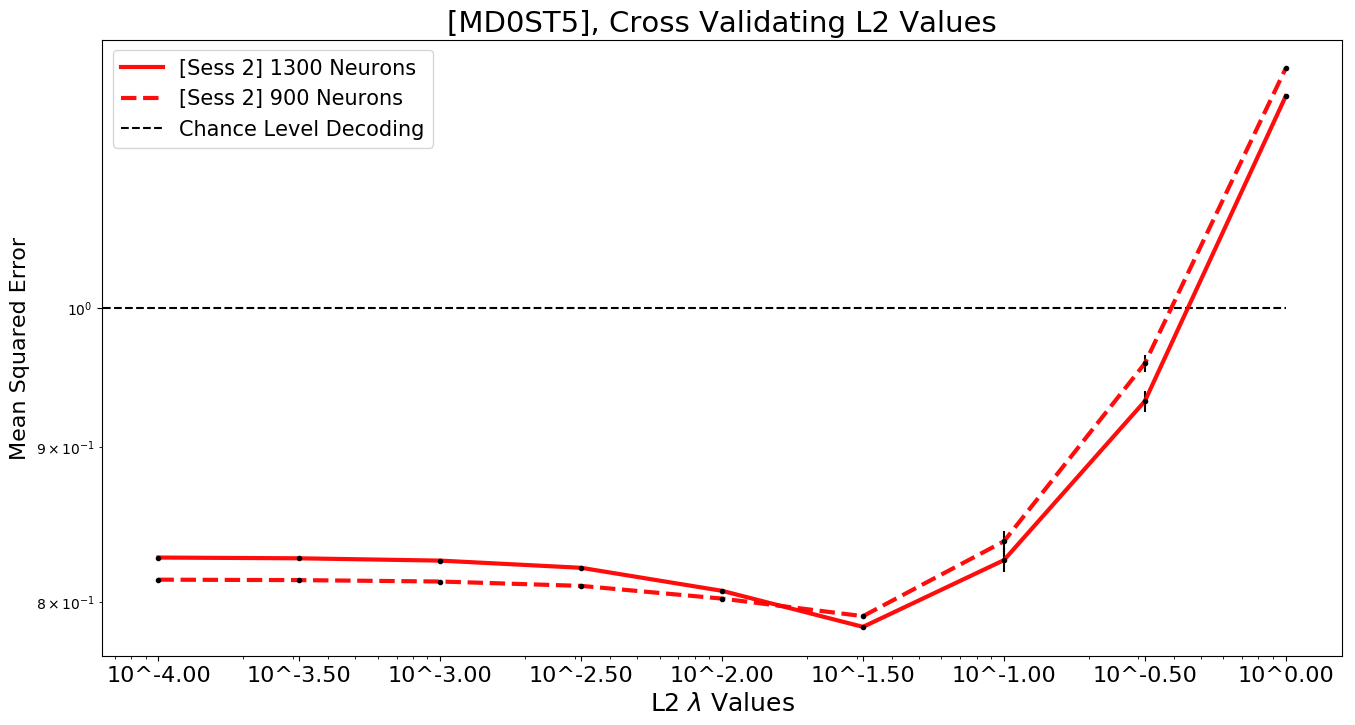

In [41]:
from scipy.stats import sem

plt.style.use('default')
fig = plt.figure(figsize=(16,8))
colors = ['red'] # ['blue', 'orange', 'green', 'red']
sessions = ['2']

for i, session in enumerate(sessions):
    color = colors[i]
    
    # Average the errors for each version and sample size
    mean_errors_1300 = np.array([np.mean(errors[session][1300][x]) for x in lambdas])
    mean_errors_400 = np.array([np.mean(errors[session][900][x]) for x in lambdas])
  
    sem_1300 = np.array([sem(errors[session][1300][x]) for x in lambdas])
    sem_400 = np.array([sem(errors[session][900][x]) for x in lambdas])
   
    print(mean_errors_1300.shape, sem_1300.shape, mean_errors_400.shape, sem_400.shape)
    plt.loglog(lambdas, mean_errors_1300, lw=3, alpha=0.95, color=color, label='[Sess %s] 1300 Neurons '%session)
    plt.errorbar(lambdas, mean_errors_1300, yerr=sem_1300, fmt='.', color='black')

    plt.loglog(lambdas, mean_errors_400, lw=3, ls='--', alpha=0.95, color=color, label='[Sess %s] 900 Neurons'%session)
    plt.errorbar(lambdas, mean_errors_400, yerr=sem_400, fmt='.', color='black')


plt.hlines(1, xmin=0, xmax=max(lambdas), linestyle='--', label='Chance Level Decoding')
plt.legend(fontsize=15)

plt.yscale('log', basey=10)
plt.xscale('log',basex=10)
# plt.ylim(min(sem_1300)-0.005,max(sem_400)+0.005)
#plt.grid(True, which="both", ls="-")

plt.xticks(lambdas, ['10^{:.2f}'.format(l) for l in np.arange(-4,0.1,0.5)],fontsize=16)
plt.xlabel(r'L2 $\lambda$ Values', fontsize=18)
plt.ylabel('Mean Squared Error', fontsize=16)
plt.title('[MD0ST5], Cross Validating L2 Values', fontsize=21)

plt.show()